# 02 - Data from the Web

In [1]:
import pandas as pd
import numpy as np
import pylab
import scipy.stats
import requests
from bs4 import BeautifulSoup

 In the notebook you will see the following "big" steps:
 1. Downloading all the data needed to perform the analysis for Master students.
 2. Cleaning data and calculating time spent at EPFL for each student.
 3. Choosing only students with a particular specialization.
 4. Calculating the average stay at EPFL for all students and for Specializations.
 5. Testing if the average stay for a particular Specialization is significantly different than for all students.


We start by downloading form from isa webpage.
Using a console in webbrowser we found a direct link to the frame containing the form on the left.
We learned we have to send a URL parameter as well thanks to POSTMAN.

In [2]:
isaBaseUrl = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS'
isaFormUrl= isaBaseUrl + ".filter"
urlParams = {'ww_i_reportModel': '133685247'}
r = requests.get(isaFormUrl, params=urlParams)
r.url + " " + str(r.status_code)

'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247 200'

We build a framework that will lets easily get a pandas Dataframe if we provide parameters we see on the isa webpage:
"Unité académique", "Période académique", "Période pédagogique", "Type de semestre".

To achieve it, we first implement a function that accepts as argument label of input from ISA webpage (for instance "Unité académique") and label of option (for instance "Informatique") and returns key-value pair that should be included in URL as GET parameter.

In [3]:
soup = BeautifulSoup(r.text, 'html.parser')
form = form = soup.find('form')

def findSelectNameAndOptionValue(inputLabel, optionLabel):
    th = form.find('th', string=inputLabel)
    td = th.nextSibling
    select = td.find('select')
    option = select.find('option', string=optionLabel)
    return (select['name'], option['value'])

findSelectNameAndOptionValue("Unité académique", "Informatique")

('ww_x_UNITE_ACAD', '249847')

Now we can build a function that generates all the parameters for GET request.
For that, beside the parameters mentioned above, we have to put in the URL some fixed parameters which we learned by using POSTMAN.
We decided to download data as HTML. This choice is encoded as fixed URL parameter too.

In [4]:
def generateParams(humanReadableParams):
    fixedParams = {
        'ww_i_reportModel': '133685247',
        'ww_i_reportModelXsl': '133685270',
        'ww_x_GPS': '-1',
    }
    params = dict([findSelectNameAndOptionValue(x, y) for (x, y) in humanReadableParams.items()])
    return {**fixedParams, **params}

# Example
exampleParams = {
    "Unité académique": "Informatique",
    "Période académique": "2016-2017",
    "Période pédagogique": "Bachelor semestre 1",
    "Type de semestre": "Semestre d'automne",
}
generateParams(exampleParams)

{'ww_i_reportModel': '133685247',
 'ww_i_reportModelXsl': '133685270',
 'ww_x_GPS': '-1',
 'ww_x_HIVERETE': '2936286',
 'ww_x_PERIODE_ACAD': '355925344',
 'ww_x_PERIODE_PEDAGO': '249108',
 'ww_x_UNITE_ACAD': '249847'}

The data for given Master stage and year comes as html table.
For `Bachelor semestre`, `Master semestre`, `Projet Master` the structure of the table is always the same,
so we can parse it with single function.

In [5]:
def extractTable(html):
    """Extract the table from HTML into a pandas Dataframe."""
    BStable = BeautifulSoup(html, 'html.parser').find('table')
    BSRows = BStable.findAll('tr')
    # BSrows[0] is just the title of the table, so we ignore it.
    headerBSRow = BSRows[1]
    headers = [th.text for th in headerBSRow]
    # We drop the last column, because it's always empty (originally it is used to make the HTML table look better).
    rows = [[tr.text for tr in BSRow.findAll('td')[:-1]] for BSRow in BSRows[2:]]
    return pd.DataFrame(data=rows, columns=headers)

Now just generate the URL parameters, get HTML, parse it to dataFrame and you get a very nice function to scrape the data for given year and Master stage.

Once again we will trick a little by using the source URL of the frame containg the table rather than URL of the whole ISA page (viva webconsole!).

In [7]:
 def getDataFrame(humanReadableParams):
    isaDataUrl = isaBaseUrl + ".html"
    r = requests.get(isaDataUrl, params=generateParams(humanReadableParams))
    return extractTable(r.text)

getDataFrame({
    "Unité académique": "Informatique",
    "Période académique": "2016-2017",
    "Période pédagogique": "Bachelor semestre 1",
    "Type de semestre": "Semestre d'automne",
}).head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper
0,Monsieur,Abbey Alexandre,,,,,,Présent,,,235688
1,Monsieur,Ahn Seongho,,,,,,Présent,,,274015
2,Madame,Alemanno Sara,,,,,,Présent,,,268410
3,Monsieur,Althaus Luca,,,,,,Présent,,,271464
4,Monsieur,Assi Karim,,,,,,Présent,,,274518


Before actually downloading the data it's worth considering what we will need.
By simply clicking things on ISA webpage we can note that data for `Projet Master` is really scarce.
The same applies to `Master semestre 4`. Therefore we decided not to use it.

We only want to estimate the time student spends at EPFL on regular studying (no Projet Master, no internship).
Still, however, we hope to exclude the students who didn't graduate. How can we guess (approximately) if a student graduated?

Well, we use 2 criteria:
1. Every student should at least appear in `Master semestre 1` and `Master semestre 2`.
2. If a student does a `Mineur` he should appear in `Master semestre 3` because it's too many ECTS to do in 2 semesters.

These criteria will also exclude some students who started before 2007, but it only makes the sample smaller.

Finally, the time spent at EPFL is calculated in semesters as the difference between chronogically first and last semesters (plus one) in which student was registered. This accounts for all weird orders in which a student could go through Master stages.

Some implementation details follow. Instead of remembering years and whether semester was in Fall or Spring, we simply order all semesters chronogically starting from 0.

We download all the tables from ISA webpage. We save each table with metainformation about what Master stage (master 1, 2, 3) and which semester chronogically it describes.

In [8]:
def getMasterData():
    """Get all needed Master data as list of tuples (semesterType, semesterNo, dataframe)."""
    startYear = 2007
    endYear = 2016
    data = []
    print("Running... ", end='')
    for year in range (startYear, endYear):
        period = "{:d}-{:d}".format(year, year + 1)
        m1Params = {
            "Unité académique": "Informatique",
            "Période académique": period,
            "Période pédagogique": "Master semestre 1",
            "Type de semestre": "Semestre d'automne",
        }
        m2Params = {
            "Unité académique": "Informatique",
            "Période académique": period,
            "Période pédagogique": "Master semestre 2",
            "Type de semestre": "Semestre de printemps",
        }
        m3Params = {
            "Unité académique": "Informatique",
            "Période académique": period,
            "Période pédagogique": "Master semestre 3",
            "Type de semestre": "Semestre d'automne",
        }
        m1 = (1, (year - startYear) * 2    , getDataFrame(m1Params)) 
        m2 = (2, (year - startYear) * 2 + 1, getDataFrame(m2Params))
        m3 = (3, (year - startYear) * 2    , getDataFrame(m3Params))
        data.extend([m1, m2, m3])
        print(">> " + str(year) + ' ', end='')
    print("...finished!")
    return data
        
masterData = getMasterData()

Running... >> 2007 >> 2008 >> 2009 >> 2010 >> 2011 >> 2012 >> 2013 >> 2014 >> 2015 ...finished!


Let's check we have a sensible number of rows in every table and the same number of colums.

In [9]:
def checkData(data):
    return [(semType, semNo, dataFrame.shape) for (semType, semNo, dataFrame) in data]

checkData(masterData)

[(1, 0, (71, 11)),
 (2, 1, (87, 11)),
 (3, 0, (65, 11)),
 (1, 2, (60, 11)),
 (2, 3, (64, 11)),
 (3, 2, (48, 11)),
 (1, 4, (52, 11)),
 (2, 5, (62, 11)),
 (3, 4, (34, 11)),
 (1, 6, (96, 11)),
 (2, 7, (109, 11)),
 (3, 6, (40, 11)),
 (1, 8, (102, 11)),
 (2, 9, (123, 11)),
 (3, 8, (67, 11)),
 (1, 10, (88, 11)),
 (2, 11, (130, 11)),
 (3, 10, (87, 11)),
 (1, 12, (104, 11)),
 (2, 13, (138, 11)),
 (3, 12, (75, 11)),
 (1, 14, (104, 11)),
 (2, 15, (151, 11)),
 (3, 14, (81, 11)),
 (1, 16, (132, 11)),
 (2, 17, (196, 11)),
 (3, 16, (92, 11))]

Yupi! It looks good. The funs begins right now.

To stay focused and make further transformations easier we:
1. keep only necessary data
2. put metainformation itself into the DataFrame
3. stack all DataFrames on top of each other into one DataFrame

Overall the number of rows doesn't change. The structure of the dataframe is rather self-explaining. Note that for now there may be multiple multiple rows related to one student. We will deal with that in a moment.

In [10]:
def prepare(triple):
    (semType, semNo, dataFrame) = triple
    df = dataFrame[['No Sciper', 'Spécialisation']].copy()
    df['Mineur'] = dataFrame['Mineur'] != ''
    df['master1'] = semType == 1
    df['master2'] = semType == 2
    df['master3'] = semType == 3
    df['semNo'] = semNo
    return df

concatedData = pd.concat(map(prepare, masterData))
concatedData.sample(5)

,No Sciper,Spécialisation,Mineur,master1,master2,master3,semNo
40,223246,,False,False,False,True,14
8,170218,,False,False,False,True,6
122,195899,,False,False,True,False,15
0,170220,,True,True,False,False,4
10,211148,,False,True,False,False,8


We aggregate the data for each student in order to know whether he ever was in master 1, 2, 3 or had a Mineur and last but not least how long he was at EPFL (see column `semNo`).

We'll treat the Specialisations individually, because as it happens some students may have more than one.

In [11]:
def aggregateData(data):
    neededData = data[['No Sciper', 'Mineur', 'master1', 'master2', 'master3', 'semNo']]
    aggregations = {
        'Mineur': 'any',
        'master1': 'any',
        'master2': 'any',
        'master3': 'any',
        'semNo': lambda x: max(x) - min(x) + 1
    }
    return data.groupby(['No Sciper'], as_index=False).agg(aggregations)
studentsData = aggregateData(concatedData)
studentsData.head()

,No Sciper,master2,semNo,Mineur,master1,master3
0,128911,True,2,False,False,True
1,129093,True,2,False,False,True
2,129326,True,2,False,False,True
3,138088,False,1,False,True,False
4,145546,False,1,False,False,True


By now we have enough information to choose "good" students; ie ones who (probably) graduated.

In [12]:
goodStudents = studentsData \
    .query('master1 and master2 and (master3 or not Mineur)') \
    [['No Sciper', 'semNo']] \
    .reset_index(drop=True)
    
print(len(goodStudents))
goodStudents.head()

743


,No Sciper,semNo
0,146330,3
1,146742,9
2,146929,2
3,147008,4
4,152232,3


Time to grab the specialisations. Let's see what you can choose at EPFL.

In [13]:
specials = concatedData \
    .query("Spécialisation != ''") \
    ['Spécialisation'] \
    .unique().tolist()
specials

['Internet computing',
 'Foundations of Software',
 'Biocomputing',
 'Signals, Images and Interfaces',
 'Computer Engineering - SP',
 'Service science',
 'Software Systems',
 'Information Security - SP',
 'Data Analytics',
 'Internet Information Systems',
 'Computer Science Theory']

We implement a function returning students (and their stay at EPFL) for a specific specialisation.

In [14]:
def findSpecialStudents(special):
    specialScipers = concatedData \
        .query("Spécialisation == @special") \
        [['No Sciper']] \
        .drop_duplicates() \
        .reset_index(drop=True)
    return specialScipers.merge(goodStudents, on='No Sciper')

specialStudents = {spec: findSpecialStudents(spec) for spec in specials}

print(len(specialStudents['Biocomputing']))
specialStudents['Biocomputing']

4


,No Sciper,semNo
0,172611,3
1,154573,5
2,169734,5
3,183185,3


We've prepared our tools and we are ready to calculate the final results.

#### Average time spent at EPFL in semesters

In [15]:
print(">> All students <<")
globalMean = goodStudents['semNo'].mean()
print("Mean in semesters: {:f}".format(globalMean))
print("Number of students: {:d}".format(len(goodStudents)))

>> All students <<
Mean in semesters: 3.107672
Number of students: 743


In [16]:
means = [df['semNo'].mean() for df in specialStudents.values()]
studentNums = [len(df) for df in specialStudents.values()]

pd.DataFrame({
    'Spécialisation': list(specialStudents.keys()),
    'Mean in semesters': means,
    'Number of students': studentNums,
    })

,Mean in semesters,Number of students,Spécialisation
0,3.725806,62,Foundations of Software
1,3.600000,5,Service science
2,2.941176,17,Software Systems
3,2.000000,1,Internet Information Systems
4,3.623656,93,Internet computing
5,3.300000,20,Computer Engineering - SP
6,2.000000,4,Data Analytics
7,4.000000,4,Biocomputing
8,4.000000,31,"Signals, Images and Interfaces"
9,2.571429,7,Information Security - SP


We shouldn't treat the Spécialisations with 1 person seriously.

In [17]:
del specialStudents['Internet Information Systems']
del specialStudents['Computer Science Theory']

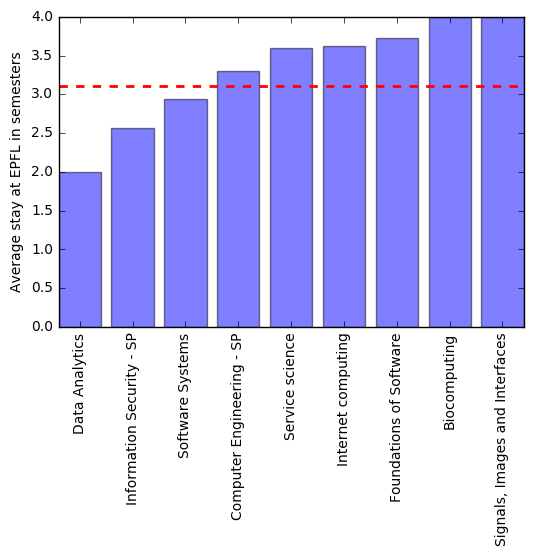

In [18]:
pairs = [(df['semNo'].mean(), spec) for (spec, df) in specialStudents.items()]
pairs.sort()
sortedMeans, sortedSpecs = zip(*pairs)

pylab.figure(1)
x = range(len(specialStudents))
pylab.xticks(x, sortedSpecs, rotation='vertical')
pylab.ylabel("Average stay at EPFL in semesters")
pylab.bar(x, sortedMeans, align='center', alpha=0.5)
pylab.axhline(globalMean, color='r', linewidth=2, linestyle='dashed')
pylab.show()

#### Is the average time spent at EPFL significantly different for students with a particular specialisation?

We use 2-sample t-test, because it checks if two populations have the same average.
The populations should have empty intersection, so we compare students from each specialisation with all the __other__ students.

In [19]:
def pvalue(spec):
    chosenStudents = specialStudents[spec]
    indexes = goodStudents['No Sciper'].isin(chosenStudents['No Sciper'])
    otherStudents = goodStudents[~indexes]
    return scipy.stats.ttest_ind(
        a=chosenStudents['semNo'],
        b=otherStudents['semNo'],
        equal_var=False).pvalue

result = [spec for spec in list(specialStudents.keys()) if pvalue(spec) <= 0.05]
print("The average stay at EPFL is significantly different for")
result

The average stay at EPFL is significantly different for


['Foundations of Software',
 'Internet computing',
 'Data Analytics',
 'Signals, Images and Interfaces']

Please take `Data Analytics` with a pinch of salt. Four people is a huge sample...